# Decision Tree Induction

In this notebook we implement a traditional ID3 induction algorithm for decision trees based on information gain / entropy and apply it to the Restaurant dataset from Russel and Norvig

In [5]:
import pandas as pd
import math
from IPython.display import Image
import pygraphviz as pgv
import random
from tabulate import tabulate

In [1]:
def entropy_v(v):
    # return the shannon entropy of a distribution
    return -sum([x*math.log(x)/math.log(2) for x in v if x>0])

In [2]:
def entropy(D):
    # compute the shannon entropy for a dataset, assuming the classes are in the
    # last column of a pandas dataframe
    vals = list(D.iloc[:,-1])
    v = [vals.count(x)/len(vals) for x in set(vals)]
    return entropy_v(v)

In [84]:
def refine(D,f,v):
    # refine a dataframe, selecting the subset where feature = value v
    return D[D[f]==v].drop(f,axis=1)

In [85]:
def avg_entropy(D, f):
    # compute the average entropy of a dataset, conditioned on the values of feature f
    vals = list(D[f])
    total_len = len(vals)
    avg_entropy = 0
    for v in set(vals):
        Ds = refine(D,f,v)
        l = len(Ds)
        avg_entropy += entropy(Ds) * l/total_len
    return avg_entropy

In [86]:
def max_info_gain(D, verbose=False):
    # given a dataset, return the feature with the highest expected info gain
    features = list(D.columns)[:-1]
    entropy_start = entropy(D)

    if verbose:
        print("Starting entropy:", entropy_start)

        # Collect average entropies in a table format
        table = []
        for f in features:
            avg_ent = avg_entropy(D, f)
            table.append([f, f"{avg_ent:0.4f}"])  # Format to 4 decimal places

        # Print the table with headers
        print(tabulate(table, headers=["Feature", "Average Entropy"], tablefmt="pretty"))

    # Calculate and return the max info gain feature
    result = max([(entropy_start - avg_entropy(D, f), random.random(), f) for f in features])

    if verbose:
        print(f"Returning: {result[2]}")
    return result[2]

### Explanation of Decision Tree Learn

1. **Node Initialization (`class node`)**: Initializes each node in the tree with attributes for `name`, `children`, `ntype` (either "leaf" or "internal"), `avg_entropy`, `entropy`, `info_gain`, and `classes` (to hold class distribution).

2. **Base Case 1 (Low Entropy)**: When the entropy of the dataset `D` is near zero, it means the data is mostly homogeneous (i.e., a single class). A leaf node is created, setting its `classes` distribution and average entropy.

3. **Base Case 2 (Max Depth)**: When `maxdepth` is zero, it indicates that we've reached the maximum depth allowed for the tree. A leaf node labeled "Mix" is created, representing a mixture of classes.

4. **Recursive Case (Internal Node)**: If the base cases are not met, the algorithm finds the feature with the highest information gain and creates an internal node for that feature. It then iterates over each unique value of the feature, creating a child subtree for each value by recursively calling `decision_tree_learn`.

5. **Class Distribution**: For each node, the distribution of classes is stored to provide a summary of the data at that node.

In [87]:
import math  # Import math for max depth limitation if needed

class node:
    def __init__(self, name, children=None, ntype=None):
        # Initialize node with a name, children (if any), and type (leaf or internal)
        self.name = name  # Name of the node (feature or class)
        self.children = children or {}  # Dictionary of children nodes (if any)
        self.ntype = ntype  # Node type: "leaf" or "internal"
        self.avg_entropy = 0  # Average entropy of the feature split at this node
        self.entropy = 0  # Entropy at this node
        self.info_gain = 0  # Information gain at this node
        self.classes = {}  # Class distribution at this node

def decision_tree_learn(D, maxdepth=math.inf, verbose=False):
    # Base case: If entropy is very low, create a leaf node with the classification
    if entropy(D) < 0.001:
        classification = D.iloc[0, -1]  # Classification based on first row in dataset
        leaf = node(name=classification, children=None, ntype="leaf")
        # Count occurrences of each class in the dataset at this leaf
        leaf.classes = {x: list(D.iloc[:, -1]).count(x) for x in set(D.iloc[:, -1])}
        leaf.avg_entropy = entropy(D)  # Set the average entropy of the leaf
        return leaf

    # Base case: If max depth is reached, create a "Mix" leaf node
    if maxdepth == 0:
        classification = "Mix"  # Indicate this node is a mixture of classes
        leaf = node(name=classification, children=None, ntype="leaf")
        # Count occurrences of each class in the dataset at this leaf
        leaf.classes = {x: list(D.iloc[:, -1]).count(x) for x in set(D.iloc[:, -1])}
        leaf.avg_entropy = entropy(D)  # Set the average entropy of the leaf
        leaf.entropy = entropy(D)  # Set the entropy of the leaf
        return leaf

    # Recursive case: Create an internal node based on the feature with max info gain
    f = max_info_gain(D, verbose=verbose)  # Get feature with highest info gain
    n = node(f, {}, "internal")  # Initialize an internal node with this feature
    n.avg_entropy = avg_entropy(D, f)  # Set average entropy after splitting by feature
    n.entropy = entropy(D)  # Set current entropy at this node
    n.info_gain = n.entropy - n.avg_entropy  # Calculate information gain for the split

    # For each unique value of the selected feature, create a subtree
    for value in set(D[f]):
        Ds = refine(D, f, value)  # Create subset of data where feature f has this value
        if Ds.shape[0] == 0:  # If subset is empty, skip to next value
            continue
        # Recursively create a child node with the subset data, decrementing maxdepth
        child = decision_tree_learn(Ds, maxdepth - 1, verbose=verbose)
        n.children[value] = child  # Add child node to the current internal node's children

    # Set class distribution for this node
    n.classes = {x: list(D.iloc[:, -1]).count(x) for x in set(D.iloc[:, -1])}
    return n  # Return the constructed node (subtree)


In [88]:
def print_tree(tree, depth = 1):
    print("."*depth,tree.name,"?",tree.classes, "ig:%4.3f ae:%4.3f e:%4.3f" % (tree.info_gain,
                                                                       tree.avg_entropy,
                                                                      tree.entropy))
    if tree.children is not None:
        for v in tree.children:
            child = tree.children[v]
            if child.ntype == "internal":
                print("="*depth+"=",v)
                print_tree(child, depth+2)
            else:
                print("="*depth+"=",v,"-->",child.name,child.classes)

In [89]:
def draw_graph(root, filename="out.png", print_infogain=True):
    G = pgv.AGraph(directed=True)
    label = "<%s <br/><font point-size=\"9.0\">%4.3f</font>>" % (root.name, root.info_gain)

    fringe = [(root,root.name)]
    G.add_node(root.name, label=label)

    id = 1
    while(len(fringe) > 0):
        n, parent_name = fringe.pop(0)
        if n.children is None: continue
        for c in n.children:
            child = n.children[c]
            child_name = str(child.name)+("%04i"%id)
            if print_infogain and child.ntype == "internal":
                label = "<%s <br/><font point-size=\"9.0\">%4.3f</font>>" % (child.name, child.info_gain)
            else:
                label = "<%s>" % (child.name)
            G.add_node(child_name, label=label)
            G.add_edge(parent_name, child_name, label=c)
            fringe.append((child, child_name))
            id +=1
    #print(G.string())
    G.layout(prog="dot")
    G.draw(filename)


## Analyze the Restaurant WillWait dataset

In [90]:
rest = pd.read_csv("restaurant2.csv")
rest

,Alt,Bar,Fri,Hun,Pat,Price,Rain,Res,Type,Est,WillWait
0,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
1,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
3,Yes,No,Yes,Yes,Full,$,No,No,Thai,10-30,Yes
4,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No
5,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
6,No,Yes,No,No,Empty,$,Yes,No,Burger,0-10,No
7,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes
8,No,Yes,Yes,No,Full,$,Yes,No,Burger,>60,No
9,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No


In [91]:
T = decision_tree_learn(rest, verbose = True, maxdepth=100)

Starting entropy: 1.0
+---------+-----------------+
| Feature | Average Entropy |
+---------+-----------------+
|   Alt   |     1.0000      |
|   Bar   |     1.0000      |
|   Fri   |     0.9793      |
|   Hun   |     0.8043      |
|   Pat   |     0.4591      |
|  Price  |     0.8043      |
|  Rain   |     1.0000      |
|   Res   |     0.9793      |
|  Type   |     1.0000      |
|   Est   |     0.7925      |
+---------+-----------------+
Returning: Pat
Starting entropy: 0.9182958340544896
+---------+-----------------+
| Feature | Average Entropy |
+---------+-----------------+
|   Alt   |     0.8091      |
|   Bar   |     0.9183      |
|   Fri   |     0.8091      |
|   Hun   |     0.6667      |
|  Price  |     0.6667      |
|  Rain   |     0.8091      |
|   Res   |     0.6667      |
|  Type   |     0.6667      |
|   Est   |     0.6667      |
+---------+-----------------+
Returning: Est
Starting entropy: 1.0
+---------+-----------------+
| Feature | Average Entropy |
+---------+--------

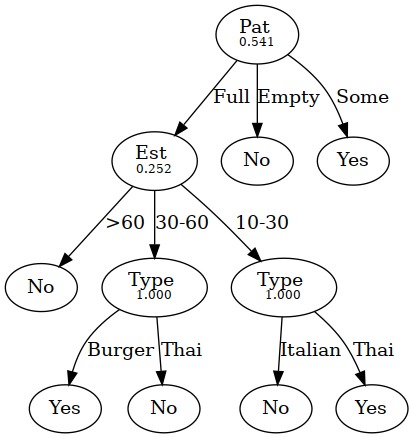

In [93]:
draw_graph(T,"restaurant.png")
Image("restaurant.png")

## Classifying with the Tree

In [94]:
def classify(T, obs):
    while T.ntype != "leaf":
        T = T.children[obs[T.name]]
    return T.name

Let's see how we do on the original training dataset

In [81]:
from tabulate import tabulate

# Initialize a list to hold table rows
table_data = []

for j in range(rest.shape[0]):
    last_column_value = rest.iloc[j, -1]  # Get the true value from the last column
    predicted_value = classify(T, rest.iloc[j])  # Get the predicted value
    table_data.append([j, last_column_value, predicted_value])  # Add row to table data

# Define headers for the table
headers = ["Observation", "True", "Predicted"]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt="pretty"))


+-------------+------+-----------+
| Observation | True | Predicted |
+-------------+------+-----------+
|      0      | Yes  |    Yes    |
|      1      |  No  |    No     |
|      2      | Yes  |    Yes    |
|      3      | Yes  |    Yes    |
|      4      |  No  |    No     |
|      5      | Yes  |    Yes    |
|      6      |  No  |    No     |
|      7      | Yes  |    Yes    |
|      8      |  No  |    No     |
|      9      |  No  |    No     |
|     10      |  No  |    No     |
|     11      | Yes  |    Yes    |
+-------------+------+-----------+
